In [1]:
# import the necessary packages
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import os

In [2]:
# specify the path to the EM-DAT dataset
emdat_dataset_path = os.path.join(
    "natural-disasters-data",
    "em-dat",
    "EMDAT_1900-2021_NatDis.csv"
)

# load the EM-DAT natural disasters dataset from disk
df = pd.read_csv(emdat_dataset_path)
df.head()

,Dis No,Year,Seq,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Entry Criteria,...,End Day,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),CPI
0,1900-9002-CPV,1900,9002,Natural,Climatological,Drought,Drought,NaN,NaN,NaN,...,NaN,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.261389
1,1900-9001-IND,1900,9001,Natural,Climatological,Drought,Drought,NaN,NaN,NaN,...,NaN,1250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.261389
2,1902-0012-GTM,1902,12,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Kill,...,18.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,25000.0,3.391845
3,1902-0003-GTM,1902,3,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Kill,...,8.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.391845
4,1902-0010-GTM,1902,10,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Kill,...,24.0,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.391845


In [3]:
# load the cleaned state names data for US tornadoes
cleaned_states_df = pd.read_pickle("tornadoes_cleaned_states.pkl")
cleaned_states_df

0                                                   [GA]
1                                           [OH, IN, TX]
2                                               [AL, MS]
3                                           [MT, IN, IL]
4                                                   [MO]
                             ...                        
139                                 [AL, GA, SC, FL, MS]
140             [IL, IA, WI, MI, IN, OH, KY, AR, TN, MO]
141                 [LA, TX, MS, SC, GA, TN, AR, NC, AL]
142                     [TX, OK, LA, MS, AL, GA, FL, VA]
143    [TN, KY, MO, MS, GA, TX, OK, IL, IN, OH, AR, W...
Name: Locations Cleaned with AI, Length: 144, dtype: object

In [4]:
# grab all tornadoes that have occurred in the United States
tornado_us_df = df[
    (df["Disaster Subsubtype"] == "Tornado") &
    (df["ISO"] == "USA")
]

# reset the indexes on both the US tornado dataframe as well as our cleaned
# state dataframe
tornado_us_df = tornado_us_df.reset_index(drop=True)
cleaned_states_df = cleaned_states_df.reset_index(drop=True)

# perform the concatenation, effectively adding the cleaned state column to
# the end of the dataframe
tornado_us_df = pd.concat([tornado_us_df, cleaned_states_df], axis=1)
tornado_us_df = tornado_us_df.rename(columns={
    "Locations Cleaned with AI": "States"
})
tornado_us_df.head()

,Dis No,Year,Seq,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Entry Criteria,...,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),CPI,States
0,1903-0010-USA,1903,10,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Kill,...,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.522300,[GA]
1,1913-0005-USA,1913,5,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Kill,...,732.0,NaN,NaN,NaN,NaN,NaN,NaN,200000.0,3.874530,"[OH, IN, TX]"
2,1920-0016-USA,1920,16,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Kill,...,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.853425,"[AL, MS]"
3,1925-0001-USA,1925,1,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Kill,...,739.0,NaN,NaN,NaN,NaN,NaN,NaN,18000.0,6.875008,"[MT, IN, IL]"
4,1927-0010-USA,1927,10,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Kill,...,87.0,NaN,NaN,NaN,NaN,NaN,NaN,22000.0,6.809780,[MO]


In [5]:
# the states column is a list of lists, so in order to count the number of
# tornadoes per state, we first need to concatenate the list of lists into
# a 1D array
flattened_states_df = pd.DataFrame(
    np.concatenate(tornado_us_df["States"].to_numpy()),
    columns=["States"]
)
flattened_states_df

,States
0,GA
1,OH
2,IN
3,TX
4,AL
...,...
762,IN
763,OH
764,AR
765,WV


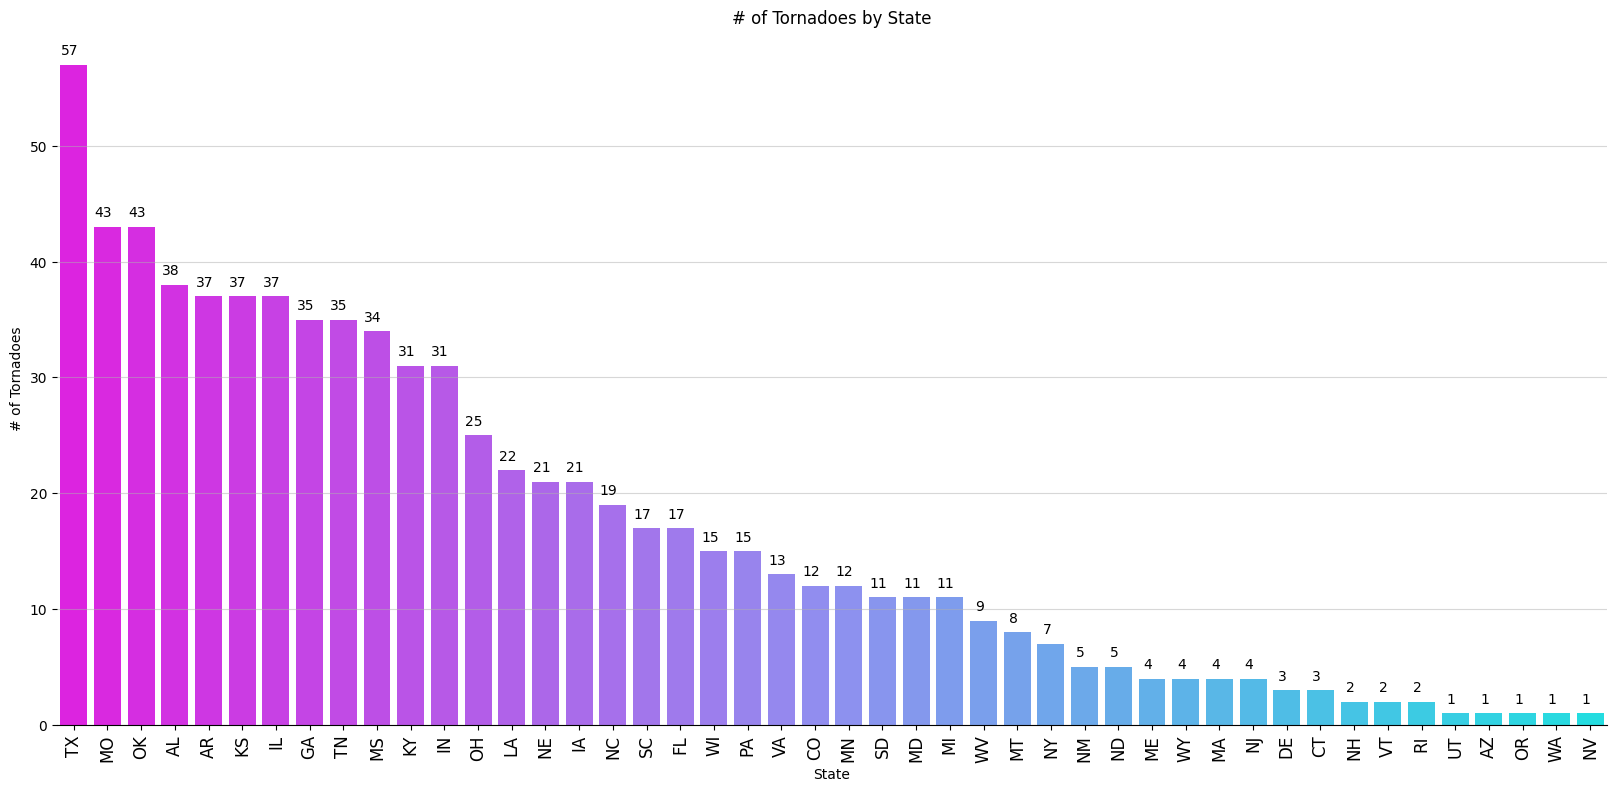

In [6]:
# count the number of times tornadoes have happened in each state
state_counts = flattened_states_df["States"].value_counts()

# initialize our figure and set tick information
plt.figure(figsize=(20, 9))
plt.xticks(rotation=90, fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)

# plot the tornado count per country
ax = sns.countplot(
    data=flattened_states_df,
    x="States",
    order=state_counts.index,
    palette="cool_r"
)
ax.grid(axis="y", alpha=0.5)

# loop over the patches for each individual bar
for p in ax.patches:
    # draw the tornado count for the current state
    ax.annotate(
        "{}".format(int(p.get_height())),
        (p.get_x() + (p.get_width() / 2.0), abs(p.get_height())),
        ha="center",
        va="bottom",
        rotation="horizontal",
        color="black",
        xytext=(-3, 5),
        textcoords="offset points"
    )

# set the axis labels and plot title
ax.set_xlabel("State")
ax.set_ylabel("# of Tornadoes")
plt.title("# of Tornadoes by State")
plt.show()

In [7]:
# the exact set of states that constitute "Tornado Alley" is not formely
# defined; however, the following states are near universally included in
# all definitions
TORNADO_ALLEY_STATES = {
    "Texas",
    "Oklahoma",
    "Kansas",
    "Nebraska",
    "South Dakota",
    "North Dakota",
    "Iowa",
    "Missouri",
    "Colorado",
}

# the following states are colloquially defined as "Dixie Alley"
DIXIE_ALLEY_STATES = {
    "Alabama",
    "Tennessee",
    "Georgia",
    "Arkansas",
    "Louisiana",
    "Mississippi",
    "Kentucky",
    "Illinois",
    "Indiana",
    "Florida",
    "South Carolina",
    "North Carolina",
}

In [8]:
# specify the path to the US census dataset
census_dataset_path = os.path.join(
    "natural-disasters-data",
    "us-census-2014",
    "usa-states-census-2014.shp"
)

# load the US census data from disk (which will allow us to easily create a
# plot of the United States using GeoPandas)
us_census_df = gpd.read_file(census_dataset_path)

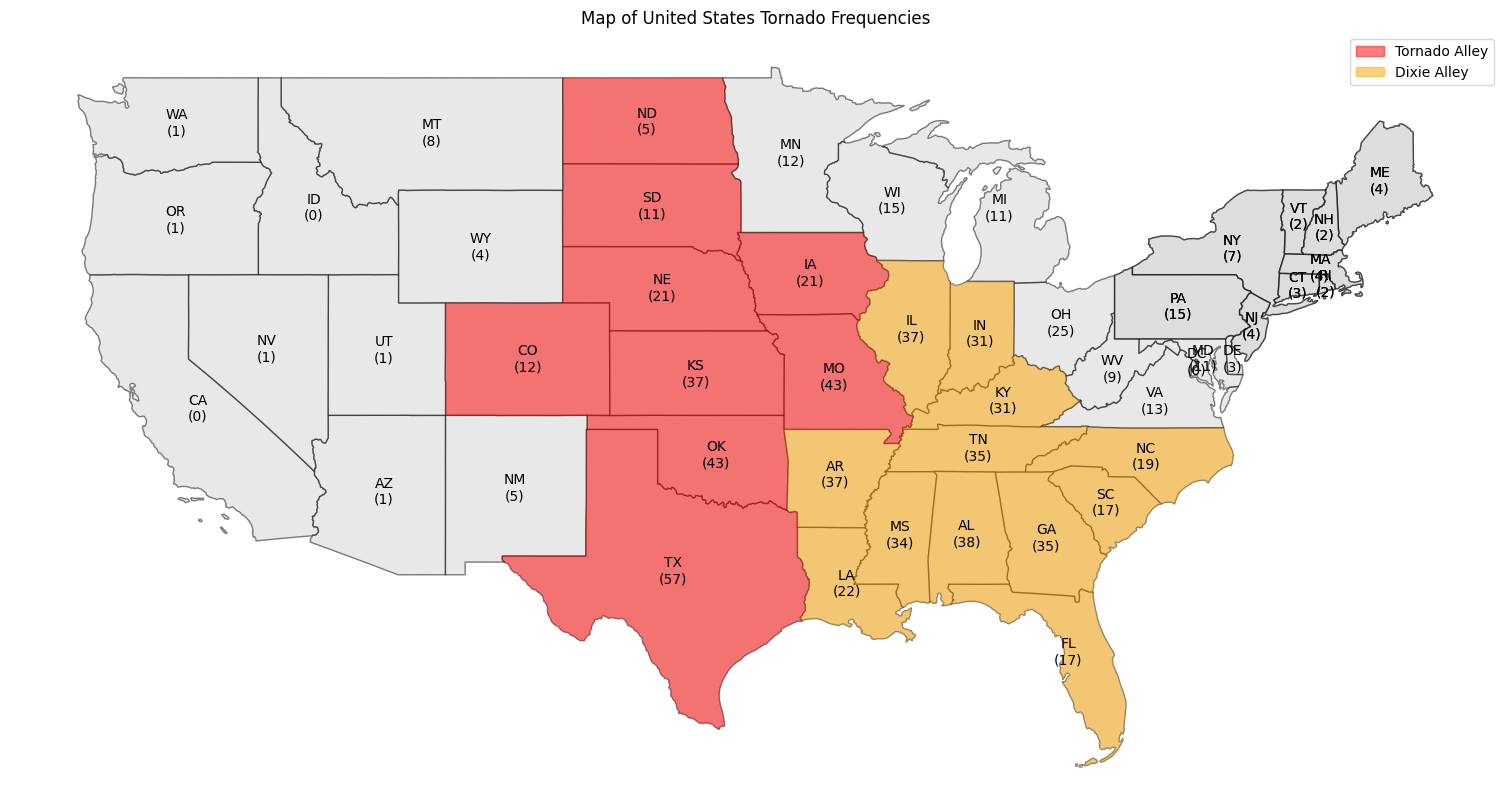

In [9]:
# initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the United States
ax = us_census_df.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

# annotate the map with both the two-letter state codes and tornado counts
us_census_df.apply(
    lambda x: ax.annotate(
        text="{}\n({})".format(x.STUSPS, state_counts.get(x.STUSPS, 0)),
        xy=x.geometry.centroid.coords[0],
        ha="center",
        va="center",
        fontsize=10
    ),
    axis=1
)

# in order to easily draw both tornado alley and dixie alley states, we first
# create a list that maps the alley states to their respective color
tornado_alleys = [
    (TORNADO_ALLEY_STATES, "red"),
    (DIXIE_ALLEY_STATES , "orange"),
]

# loop over the alleys
for (alley, color) in tornado_alleys:
    # highlight all states that are part of the alley
    alley_states = us_census_df["NAME"].isin(alley)
    alley_states = us_census_df[alley_states]
    alley_states.plot(ax=ax, color=color, alpha=0.5)

# turn off axis ticks, and despine the plot
ax.set_xticks([])
ax.set_yticks([])
sns.despine(top=True, right=True, bottom=True, left=True)

# create custom legend patches for both tornado alley and dixie alley
tornado_alley_patch = mpatches.Patch(
    color="red",
    label="Tornado Alley",
    alpha=0.5
)
dixie_alley_patch = mpatches.Patch(
    color="orange",
    label="Dixie Alley",
    alpha=0.5
)

# add the patches to the plot
ax.legend(handles=[tornado_alley_patch, dixie_alley_patch])

# set the plot title
plt.title("Map of United States Tornado Frequencies")
plt.show()